In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
from datetime import datetime
import re
import numpy as np
import warnings

In [2]:
warnings.filterwarnings("ignore")

Lets start off with making a plot that shows the monthly scrobbles starting at when the account was made. We can then analyze and find out what the graph tells us.

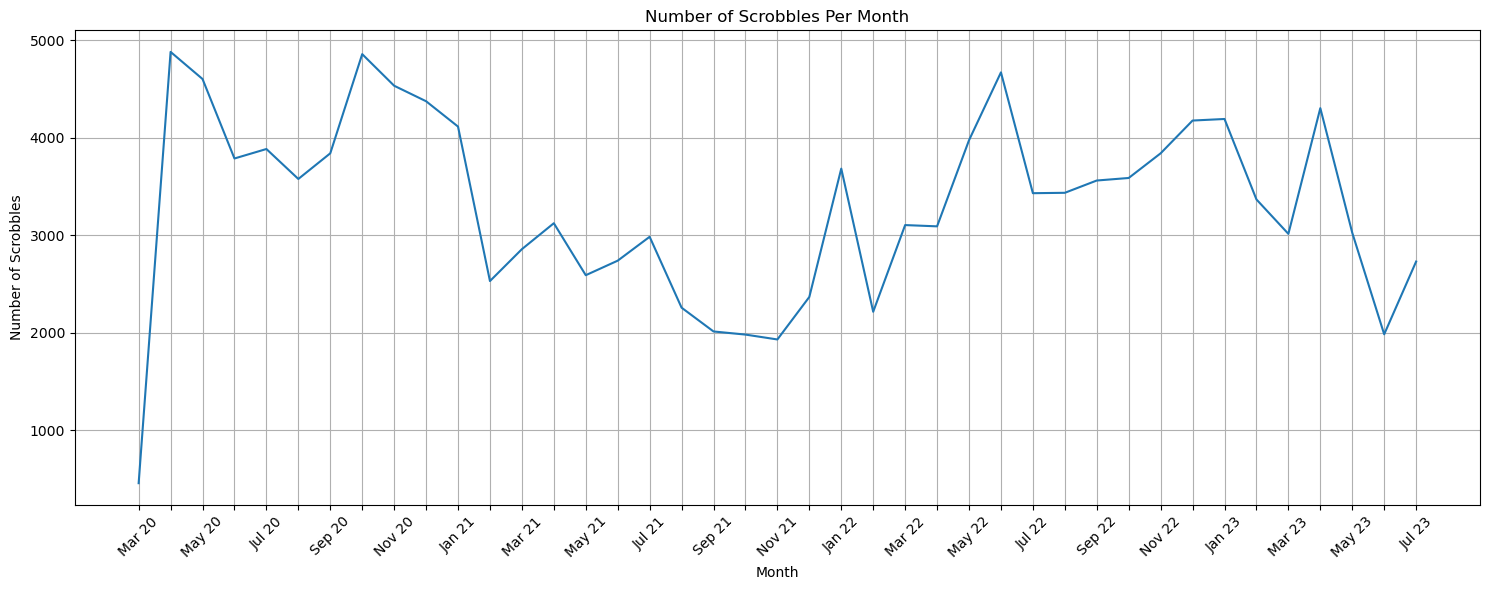

In [3]:
def convert_date(date_str):
    return datetime.strptime(date_str, '%d %b %Y, %H:%M')

# Load the data
df = pd.read_csv('lastfm_data2.csv')

# Remove leading and trailing whitespace from column names
df.columns = df.columns.str.strip()

# Drop rows with missing date values
df = df.dropna(subset=['date'])

# Apply the function to the 'date' column
df['date'] = df['date'].apply(convert_date)

# Set the date as the DataFrame's index
df.set_index('date', inplace=True)

# Reset the index of the DataFrame
df_reset = df.reset_index()

# Extract the year and month from the date
df_reset['year'] = df_reset['date'].dt.year
df_reset['month'] = df_reset['date'].dt.month

# Create a 'year-month' column for grouping
df_reset['year_month'] = df_reset['date'].dt.to_period('M')

# Group by 'year_month' and count the number of scrobbles
monthly_scrobbles = df_reset.groupby('year_month').size().reset_index(name='counts')

# Convert 'year_month' to string format in 'Mon YY' format
monthly_scrobbles['year_month'] = monthly_scrobbles['year_month'].dt.strftime('%b %y')

# Plot the result using seaborn
plt.figure(figsize=(15,6))
plot = sns.lineplot(data=monthly_scrobbles, x='year_month', y='counts')
plt.title('Number of Scrobbles Per Month')
plt.xlabel('Month')
plt.ylabel('Number of Scrobbles')
plt.grid(True)

# Get the current x-tick labels and set every 2nd label to visible
for ind, label in enumerate(plot.get_xticklabels()):
    if ind % 2 == 0:  # every 2nd label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

This does make lots of sense considering the highest music listening was done during quarantine when we were in lockdown and online classes. Then as time continued and Iwent back in person for high school and college we saw a dip. 

In [4]:
# Group by 'year_month' and 'artist' to get scrobbles per artist per month
artist_counts = df_reset.groupby(['year_month', 'artist']).size().reset_index(name='counts')

# Get the top artist for each month
top_artist_per_month = artist_counts.loc[artist_counts.groupby('year_month')['counts'].idxmax()]

Next lets see my top artists each month.

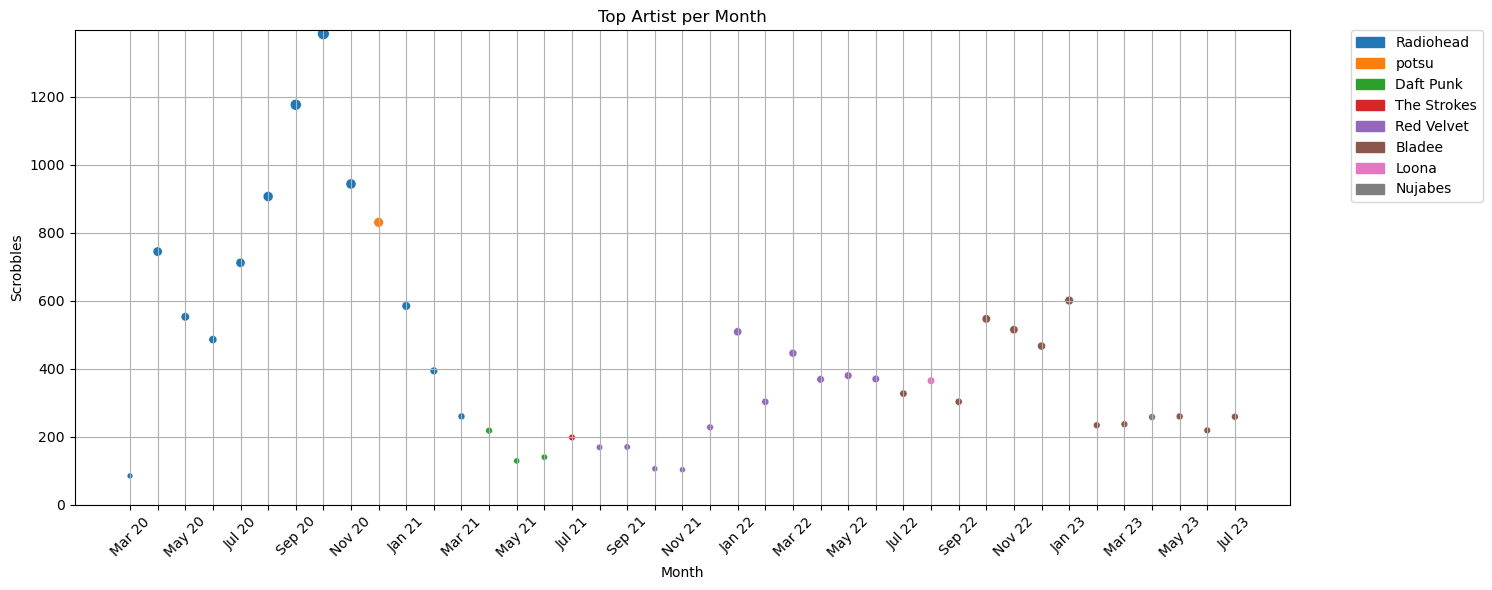

In [5]:
# Convert 'year_month' back to datetime format for sorting
top_artist_per_month['year_month'] = pd.to_datetime(top_artist_per_month['year_month'].dt.strftime('%Y-%m'), format='%Y-%m')

# Sort the DataFrame by 'year_month' before plotting
top_artist_per_month = top_artist_per_month.sort_values('year_month')

# Convert 'year_month' back to string format for plotting
top_artist_per_month['year_month'] = top_artist_per_month['year_month'].dt.strftime('%b %y')

# Create a dot plot with seaborn
plt.figure(figsize=(15,6))
plot = sns.scatterplot(data=top_artist_per_month, x='year_month', y='counts', size='counts', hue='artist', palette='tab10', alpha=1, legend=False)

# Create a color legend
artists = top_artist_per_month['artist'].unique()
colors = sns.color_palette('tab10', n_colors=len(artists))
patches = [mpatches.Patch(color=colors[i], label=artist) for i, artist in enumerate(artists)]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Set the size range for the dots
plot.set_ylim(0, top_artist_per_month['counts'].max() + 10)

# Adjust the x-axis labels to show only every other month
for ind, label in enumerate(plot.get_xticklabels()):
    if ind % 2 == 0:  # every 2nd label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)

plt.title('Top Artist per Month')
plt.xlabel('Month')
plt.ylabel('Scrobbles')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


It's interesting to see when my music taste changed especially with how we can see how Radiohead dominated for almost a year, but then I started getting burned out by their music and started listening to many other artists.

In [6]:
# Load friend's dataset
df_friend = pd.read_csv('gol3m521.csv')

# Check the first few rows of the DataFrame
print(df_friend.head())

           Dijon                                 Skin         Skin.1  \
0     Red Velvet  ‘The ReVe Festival 2022 - Birthday’        BYE BYE   
1         Eve Ai                           垂直活著水平留戀著。  Forever Young   
2   Zombie Juice              Love Without Conditions            Fly   
3     Charli XCX                  how i'm feeling now        anthems   
4  Genesis Owusu                Smiling with No Teeth     Centrefold   

   17 Jul 2023 19:17  
0  17 Jul 2023 19:13  
1  17 Jul 2023 19:07  
2  17 Jul 2023 19:04  
3  17 Jul 2023 19:02  
4  17 Jul 2023 18:57  


Now with my friends csv file lets compare out music tastes.

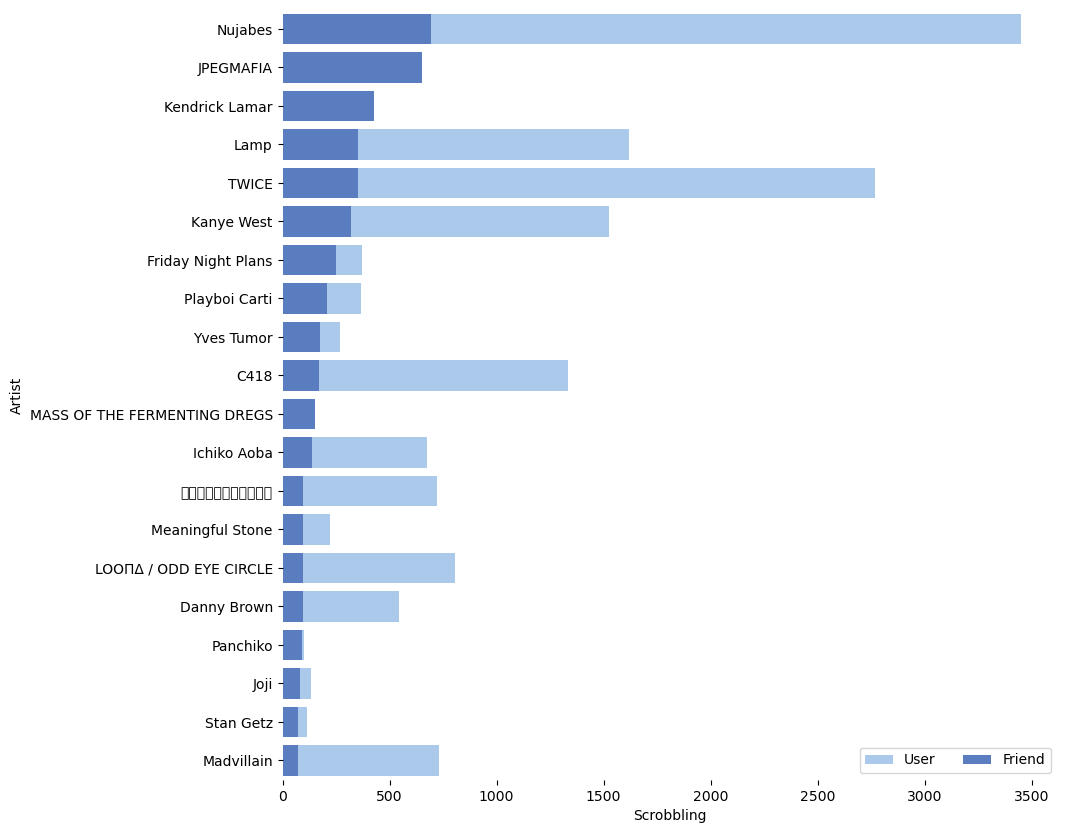

In [7]:
# Find the top artists for user
top_artists_user = df['artist'].value_counts().reset_index()
top_artists_user.columns = ['artist', 'user_count']

# Find the top artists for friend
top_artists_friend = df_friend['Dijon'].value_counts().reset_index()
top_artists_friend.columns = ['artist', 'friend_count']

# Merge the two dataframes on artist
merged_artists = pd.merge(top_artists_user, top_artists_friend, how='inner', on='artist')

# Create a new column 'overlap_count' that is the minimum of 'user_count' and 'friend_count'
merged_artists['overlap_count'] = merged_artists[['user_count', 'friend_count']].min(axis=1)

# Sort the DataFrame by 'overlap_count' in descending order
merged_artists = merged_artists.sort_values('overlap_count', ascending=False)

# Select the top 20 artists with the most overlap
top_overlap = merged_artists.head(20)

# Plot the result
plt.figure(figsize=(10,10))
sns.set_color_codes("pastel")
sns.barplot(x='user_count', y='artist', data=top_overlap, label='User', color='b')
sns.set_color_codes("muted")
sns.barplot(x='friend_count', y='artist', data=top_overlap, label='Friend', color='b')
plt.legend(ncol=2, loc="lower right", frameon=True)
plt.xlabel('Scrobbling')
plt.ylabel('Artist')
sns.despine(left=True, bottom=True)
plt.show()


Interesting to see the different types of artists that we share and how for most of these artists I have many more scrobbles which is most likely due to me listening to music more than him.

Next let's see my listening habits by the day and hour to see what times i listen to music the most.

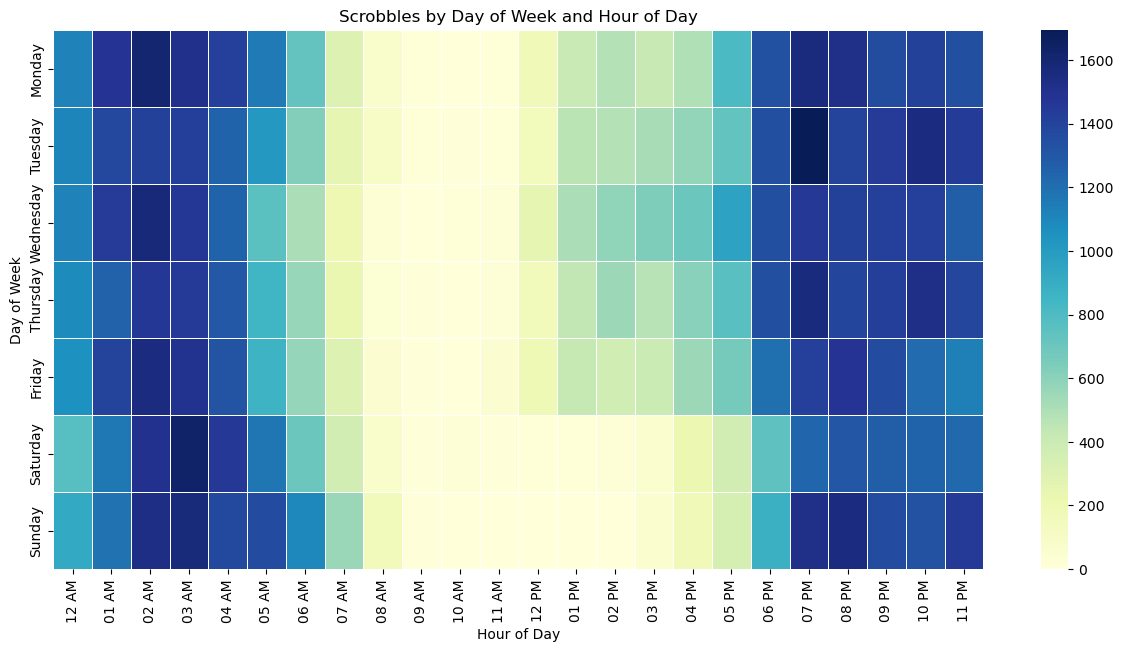

In [19]:
# Extract day of the week and hour of the day from the 'date' column
df_reset['day_of_week'] = df_reset['date'].dt.day_name()
df_reset['hour_of_day'] = df_reset['date'].dt.strftime('%I %p')
df_reset['hour_24'] = df_reset['date'].dt.hour

# Sort the DataFrame by 'day_of_week' and 'hour_24' before creating the pivot
df_sorted = df_reset.sort_values(['day_of_week', 'hour_24'])

# Create a pivot table for the heatmap using the sorted DataFrame
pivot_sorted = df_sorted.groupby(['day_of_week', 'hour_of_day']).size().unstack().fillna(0)

# Reorder the days of the week from Monday to Sunday
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
pivot_sorted = pivot_sorted.reindex(day_order)

# Define the 24-hour format order
hour_order = ["12 AM", "01 AM", "02 AM", "03 AM", "04 AM", "05 AM", "06 AM", "07 AM", 
              "08 AM", "09 AM", "10 AM", "11 AM", "12 PM", "01 PM", "02 PM", "03 PM", 
              "04 PM", "05 PM", "06 PM", "07 PM", "08 PM", "09 PM", "10 PM", "11 PM"]

# Reorder the columns of the pivot table based on the 24-hour format
pivot_sorted = pivot_sorted[hour_order]

# Create the adjusted heatmap
plt.figure(figsize=(15, 7))
sns.heatmap(pivot_sorted, cmap='YlGnBu', linewidths=0.5)
plt.title('Scrobbles by Day of Week and Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.show()


We can clearly see that I listen to music deep into the night and also sheds some light on my sleep schedule and how I sleep to music. You can clearly see a dip in scrobbles during school hours and when im asleep as well.

Lastly let's see a pie chart of the different genres of music I listen to.

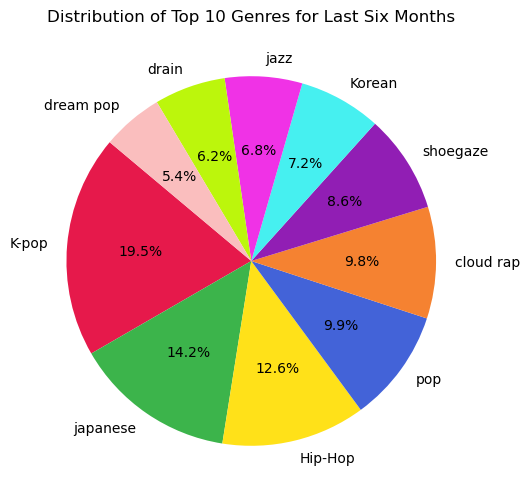

In [21]:
def standardize_genres(genre):
    """Standardize genre names."""
    if genre in ["Kpop", "k-pop"]:
        return "K-pop"
    return genre


# Filter the data for the last six months
now = datetime.now()
df_last_six_months = df_reset[df_reset['date'] > now - pd.DateOffset(months=6)]

# Split the 'tags' column into separate genres
genres_last_six_months = df_last_six_months['tags'].str.split(', ', expand=True).stack()

# Apply the genre standardization function to the genres
standardized_genres = genres_last_six_months.apply(standardize_genres)

# Count the occurrences of each standardized genre
standardized_genre_counts = standardized_genres.value_counts()

# Select the top 10 standardized genres
top_standardized_genres = standardized_genre_counts.head(10)

# Calculate the proportion of each standardized genre
standardized_genre_proportions = top_standardized_genres / top_standardized_genres.sum()

# Define a distinct color palette
colors = [
    "#e6194B", "#3cb44b", "#ffe119", "#4363d8", "#f58231", 
    "#911eb4", "#46f0f0", "#f032e6", "#bcf60c", "#fabebe"
]

# Create the pie chart
plt.figure(figsize=(10, 6))
plt.pie(standardized_genre_proportions, labels=standardized_genre_proportions.index, 
        autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Distribution of Top 10 Genres for Last Six Months')
plt.show()
